In [6]:
import numpy as np

def oblicz_homografie_sage(punkty_zrodlowe, punkty_docelowe):
    """
    Oblicza macierz homografii H przy użyciu metody najmniejszych kwadratów w SageMath.
    punkty_zrodlowe: lista krotek [(x1, y1), (x2, y2), ...] ze zdjęcia, które chcemy przekształcić
    punkty_docelowe: lista krotek [(x1, y1), (x2, y2), ...] ze zdjęcia bazowego (do którego pasujemy)
    """
    
    # Sprawdzenie czy mamy wystarczającą liczbę punktów (minimum 4)
    if len(punkty_zrodlowe) < 4:
        raise ValueError("Potrzebujesz co najmniej 4 par punktów!")

    macierz_A_rows = []
    wektor_b_rows = []

    # Budujemy układ równań. To jest odpowiednik pętli z Twojego zdjęcia image_14eda5.png,
    # ale przygotowany pod macierze Sage.
    for (xs, ys), (xd, yd) in zip(punkty_zrodlowe, punkty_docelowe):
        # Równanie dla x: h1*xs + h2*ys + h3 - h7*xs*xd - h8*ys*xd = xd
        # Równanie dla y: h4*xs + h5*ys + h6 - h7*xs*yd - h8*ys*yd = yd
        
        # Wiersz 1 (dla x)
        # Zmienne to [h1, h2, h3, h4, h5, h6, h7, h8]
        row_x = [xs, ys, 1, 0, 0, 0, -xs*xd, -ys*xd]
        macierz_A_rows.append(row_x)
        wektor_b_rows.append(xd)
        
        # Wiersz 2 (dla y)
        row_y = [0, 0, 0, xs, ys, 1, -xs*yd, -ys*yd]
        macierz_A_rows.append(row_y)
        wektor_b_rows.append(yd)

    # Tworzymy macierze w Sage (korzystając z ciała liczb wymiernych QQ lub rzeczywistych RR)
    A = matrix(RR, macierz_A_rows)
    b = vector(RR, wektor_b_rows)

    # --- TU DZIEJE SIĘ MAGIA Z TWOICH NOTATEK ---
    # Rozwiązujemy układ metodą najmniejszych kwadratów: x = (A^T * A)^-1 * A^T * b
    # Sage ma do tego metodę, ale możemy zapisać to jawnym wzorem z notatek:
    
    at_a = A.transpose() * A
    at_b = A.transpose() * b
    
    # Rozwiązanie h (wektor współczynników)
    h = at_a.inverse() * at_b
    
    # Konwertujemy wynik z powrotem do formatu, który zrozumie funkcja rysująca (np. macierz 3x3)
    # Pamiętamy, że h9 = 1 (współrzędne jednorodne)
    H_list = list(h) + [1.0] 
    
    # Zwracamy jako macierz numpy (bo biblioteki graficzne wolą numpy)
    return np.array(H_list).reshape(3, 3)

print("Funkcja gotowa. Czekam na dane!")

Funkcja gotowa. Czekam na dane!


Zdjęcia wczytane. Baza: 4096x3072, Źródło: 4096x3072
Macierz Homografii obliczona.
Nowy rozmiar panoramy: 9604x7191
Przesunięcie (offset): x=-0.00, y=2462.65


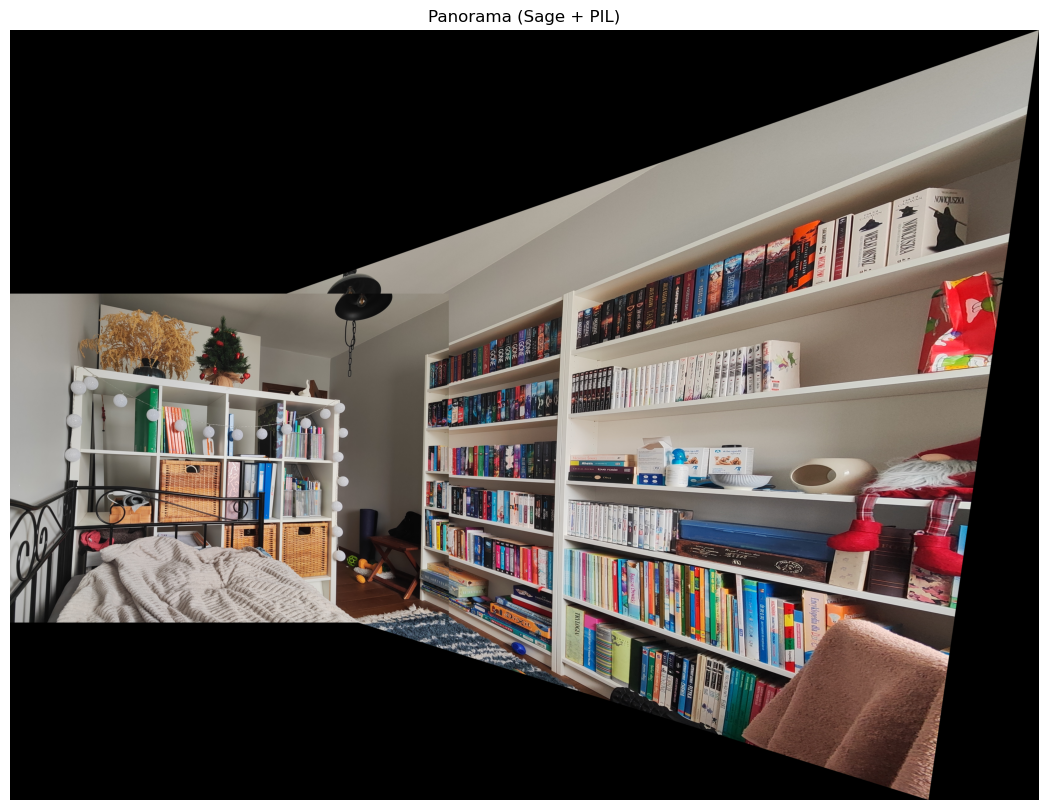

In [26]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sage.all import *

# --- 1. DANE WEJŚCIOWE ---
# Twoje 12 par punktów
punkty_zrodlo_img2 = [ 
    (814, 307), (1550, 665), (873, 786), (1380, 834), (2217, 751), (1526, 1038), 
    (2235, 1470), (965, 1574), (2076, 2304), (1420, 2679), (2061, 2723), (2188, 2708)
]

punkty_cel_img1 = [
    (2339, 399), (2992, 606), (2358, 827), (2837, 805), (3894, 565), (3079, 992), 
    (3907, 1421), (2561, 1540), (3699, 2382), (2997, 2648), (3681, 2855), (3843, 2867)
]

# Wczytujemy zdjęcia (PIL jest zawsze dostępny)
img1_base = Image.open("1000031844.jpg") # Baza (lewe)
img2_src = Image.open("1000031845.jpg")  # Źródło (prawe, do wygięcia)

w1, h1 = img1_base.size
w2, h2 = img2_src.size

print(f"Zdjęcia wczytane. Baza: {w1}x{h1}, Źródło: {w2}x{h2}")

# --- 2. MATEMATYKA SAGE (Metoda Najmniejszych Kwadratów) ---
rows_A = []
rows_b = []

for (xs, ys), (xd, yd) in zip(punkty_zrodlo_img2, punkty_cel_img1):
    # Wiersz dla x
    rows_A.append([xs, ys, 1, 0, 0, 0, -xs*xd, -ys*xd])
    rows_b.append(xd)
    # Wiersz dla y
    rows_A.append([0, 0, 0, xs, ys, 1, -xs*yd, -ys*yd])
    rows_b.append(yd)

# Rozwiązanie w Sage
A = matrix(RR, rows_A)
b = vector(RR, rows_b)
h_sage = (A.transpose() * A).inverse() * (A.transpose() * b)

# Konwersja do macierzy NumPy 3x3 (dodajemy 1 na końcu)
H = np.array(list(h_sage) + [1.0]).reshape(3, 3)
print("Macierz Homografii obliczona.")

# --- 3. OBLICZANIE ROZMIARU PŁÓTNA (BEZ OpenCV) ---
# To jest kluczowy moment - musimy ręcznie sprawdzić, gdzie wylądują rogi zdjęcia 2
# Rogi zdjęcia 2 (x, y, 1)
corners_src = np.array([
    [0, 0, 1],
    [w2, 0, 1],
    [w2, h2, 1],
    [0, h2, 1]
]).T 

# Mnożymy macierz H przez współrzędne rogów (rzutowanie)
corners_transformed = np.dot(H, corners_src)
# Normalizacja (dzielenie przez 'w', czyli trzeci wymiar)
corners_transformed = corners_transformed / corners_transformed[2]

# Teraz mamy nowe współrzędne rogów img2. Łączymy je z rogami img1 (które są statyczne: 0,0, w1,h1)
all_x = np.concatenate((corners_transformed[0], [0, w1]))
all_y = np.concatenate((corners_transformed[1], [0, h1]))

# Szukamy skrajnych wartości (obwiednia)
x_min = np.min(all_x)
y_min = np.min(all_y)
x_max = np.max(all_x)
y_max = np.max(all_y)

# Obliczamy rozmiar nowego płótna i przesunięcie
shift_x = -x_min  # Tyle musimy przesunąć w prawo, jeśli wyszło ujemne
shift_y = -y_min  # Tyle w dół
new_w = int(np.ceil(x_max - x_min))
new_h = int(np.ceil(y_max - y_min))

print(f"Nowy rozmiar panoramy: {new_w}x{new_h}")
print(f"Przesunięcie (offset): x={shift_x:.2f}, y={shift_y:.2f}")

# --- 4. PRZEKSZTAŁCENIE I SKLEJANIE (PIL) ---

# Macierz przesunięcia (Translacja)
T = np.array([
    [1, 0, shift_x],
    [0, 1, shift_y],
    [0, 0, 1]
])

# Macierz finalna dla obrazu (Najpierw Homografia, potem Przesunięcie)
# M_final mapuje piksele Z Źródła DO Panoramy
M_final = np.dot(T, H)

# ALE: Funkcja transform w PIL wymaga macierzy odwrotnej! 
# (Ona pyta: "dla tego piksela panoramy, skąd mam wziąć kolor z oryginału?")
M_inv = np.linalg.inv(M_final)

# Normalizujemy (ostatni element musi być 1) i spłaszczamy do formatu PIL (8 liczb)
M_pil = M_inv / M_inv[2, 2]
coeffs = M_pil.flatten()[:8]

# Tworzymy panoramę
# 1. Transformujemy zdjęcie 2 na duże, puste płótno
img2_warped = img2_src.transform(
    (new_w, new_h),
    Image.PERSPECTIVE,
    coeffs,
    Image.BICUBIC
)

# 2. Tworzymy puste tło i wklejamy img1 (baza) z przesunięciem
panorama = Image.new("RGBA", (new_w, new_h), (0, 0, 0, 0))

# Konwersja img1 do RGBA (żeby obsłużyć przezroczystość)
img1_rgba = img1_base.convert("RGBA")

# Najpierw wklejamy wygięte zdjęcie 2
panorama.paste(img2_warped, (0, 0))

# Potem nakładamy zdjęcie 1 (bazę) w odpowiednim miejscu
# Używamy maski, żeby wkleić tylko treść zdjęcia, a nie przezroczyste tło (jeśli by było)
panorama.paste(img1_rgba, (int(shift_x), int(shift_y)), mask=img1_rgba)

# --- 5. WYŚWIETLANIE ---
plt.figure(figsize=(15, 10))
plt.imshow(panorama)
plt.axis('off')
plt.title("Panorama (Sage + PIL)")
plt.show()

Ustalam wysokość na podstawie oryginału: od wiersza 2462 do 5534
Obliczona szerokość: od kolumny 0 do 9604


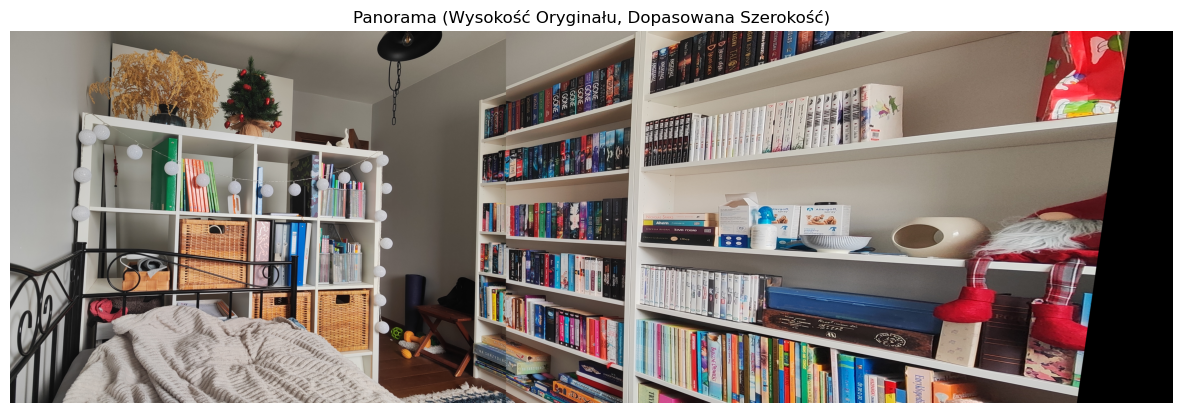

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# --- CIĘCIE: STAŁA WYSOKOŚĆ, OBLICZANA SZEROKOŚĆ ---

# 1. Zamiana panoramy na macierz
pano_arr = np.array(panorama)

# 2. Ustalamy sztywne ramy pionowe (Wysokość Oryginału)
# Zdjęcie bazowe zostało wklejone w punkcie (shift_x, shift_y)
y_start = int(shift_y)
y_end = int(shift_y + h1)

# Zabezpieczenie na wypadek drobnych błędów zaokrągleń
y_start = max(0, y_start)
y_end = min(pano_arr.shape[0], y_end)

print(f"Ustalam wysokość na podstawie oryginału: od wiersza {y_start} do {y_end}")

# 3. Wycinamy pas o tej wysokości
# To jest nasz "kandydat" na panoramę, teraz musimy tylko przyciąć go na boki
strip = pano_arr[y_start:y_end, :]

# 4. Obliczamy szerokość (Szukamy kolumn bez dziur)
# Tworzymy maskę: True tam, gdzie piksel NIE jest pusty
is_solid = strip[:, :, 3] > 0  # Sprawdzamy kanał Alpha

# Sprawdzamy kolumny: Kolumna jest OK tylko wtedy, gdy CAŁA jest pełna (od góry do dołu w tym pasie)
# axis=0 oznacza, że "zgniatamy" pionowo sprawdzając logiczne AND
valid_columns = np.all(is_solid, axis=0)

# 5. Znajdujemy granice cięcia w poziomie
# Wiemy, że zdjęcie bazowe (img1) jest w pełni wypełnione.
# Zaczyna się ono na 'shift_x' i ma szerokość 'w1'.
center_guess = int(shift_x + w1 / 2)

# Szukamy lewej krawędzi (idziemy w lewo od środka, aż trafimy na fałsz)
# np.where zwraca indeksy, gdzie jest False. Szukamy ostatniego False przed środkiem.
invalid_indices = np.where(~valid_columns)[0]

# Lewa granica:
# Znajdź indeksy 'złych' kolumn, które są po lewej stronie od środka
bad_left = invalid_indices[invalid_indices < center_guess]
if len(bad_left) > 0:
    x_start = bad_left[-1] + 1 # Pierwsza dobra kolumna po ostatniej złej
else:
    x_start = 0 # Jeśli nie ma złych kolumn po lewej, bierzemy od początku

# Prawa granica:
# Znajdź indeksy 'złych' kolumn, które są po prawej stronie od środka
bad_right = invalid_indices[invalid_indices > center_guess]
if len(bad_right) > 0:
    x_end = bad_right[0] # Pierwsza zła kolumna to koniec obrazka
else:
    x_end = strip.shape[1] # Jeśli nie ma złych kolumn po prawej, bierzemy do końca

print(f"Obliczona szerokość: od kolumny {x_start} do {x_end}")

# 6. Finalne cięcie
final_strip = strip[:, x_start:x_end]
final_panorama_fixed_height = Image.fromarray(final_strip)

# 7. Wyświetlenie
plt.figure(figsize=(15, 8))
plt.imshow(final_panorama_fixed_height)
plt.title("Panorama (Wysokość Oryginału, Dopasowana Szerokość)")
plt.axis('off')
plt.show()

# Zapisz wynik
final_panorama_fixed_height.save("Panorama_Final_Fixed_Height.png")

In [ ]:
#Obliczanie macierzy homografii metoda najmnijeszych kwadratow

In [25]:
#3